In [1]:
from datasets_dataloader_pytorch import CustomDataset, load_data
from sklearn.model_selection import train_test_split
import numpy as np
import torch

from CAMELOT import CamelotModel

import tensorflow as tf
from utils import calc_pred_loss, calc_dist_loss, calc_clus_loss

In [14]:
dataset = CustomDataset()

# Stratified Sampling for train and val
train_val_idx, test_idx = train_test_split(np.arange(len(dataset)),
                                             test_size=0.4,
                                             random_state=2323,
                                             shuffle=True,
                                             stratify=np.argmax(dataset.y,axis=-1))

# Subset dataset for train and val
train_val_dataset = dataset.get_subset(train_val_idx)
test_dataset = dataset.get_subset(test_idx)

train_idx, val_idx = train_test_split(np.arange(len(train_val_idx)),
                                             test_size=0.4,
                                             random_state=2323,
                                             shuffle=True,
                                             stratify=np.argmax(train_val_dataset.y,axis=-1))

train_dataset = train_val_dataset.get_subset(train_idx)
val_dataset = train_val_dataset.get_subset(val_idx)

train_loader, val_loader, test_loader = load_data(train_dataset, val_dataset, test_dataset)


MIMIC data has been subsettted to the following features: 
 ['DBP', 'ESI', 'HR', 'RR', 'SBP', 'SPO2', 'TEMP', 'age', 'gender'].


100%|██████████| 7701/7701 [00:09<00:00, 839.68it/s]


In [54]:
np.unique(np.argmax(dataset.y, axis=-1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([  50, 1629, 5874,  148], dtype=int64))

In [19]:
from sklearn.cluster import KMeans
import numpy as np
from tqdm import trange

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from model_utils import Encoder, Identifier, Predictor
from utils import calc_pred_loss


class CamelotModel(nn.Module):
    def __init__(self, input_shape, num_clusters=10, latent_dim=32, seed=4347, output_dim=4,
                 alpha=0.01, beta=0.01, regularization=(0.01, 0.01), dropout=0.6,
                 cluster_rep_lr=0.001, weighted_loss=True, attention_hidden_dim=20,
                 mlp_hidden_dim=30):

        super().__init__()
        torch.random.manual_seed(seed)
        self.seed = seed

        self.input_shape = input_shape
        self.num_clusters = num_clusters
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.alpha = alpha
        self.beta = beta
        self.regularization = regularization
        self.dropout = dropout
        self.cluster_rep_lr = cluster_rep_lr
        self.weighted_loss = weighted_loss
        self.attention_hidden_dim = attention_hidden_dim
        self.mlp_hidden_dim = mlp_hidden_dim

        # three newtorks
        self.Encoder = Encoder(self.input_shape, self.attention_hidden_dim, self.latent_dim, self.dropout)
        self.Identifier = Identifier(self.latent_dim, self.mlp_hidden_dim, self.dropout, self.num_clusters)
        self.Predictor = Predictor(self.latent_dim, self.mlp_hidden_dim, self.dropout, self.output_dim)

        # Cluster Representation params
        self.cluster_rep_set = torch.zeros(
            size=[self.num_clusters, self.latent_dim], dtype=torch.float32, requires_grad=True)

        self.loss_weights = None

    def forward(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        samples = self.get_sample(probs)
        representations = self.get_representations(samples)
        return self.Predictor(representations)

    def forward_pass(self, x):
        z = self.Encoder(x)
        probs = self.Identifier(z)
        # print(probs.shape)
        samples = self.get_sample(probs)
        # print(samples.shape)
        representations = self.get_representations(samples)
        # print(representations.shape)
        return self.Predictor(representations), probs

    def get_sample(self, probs):
        logits = - torch.log(probs.reshape(-1, self.num_clusters))
        samples = torch.multinomial(logits, num_samples=1)
        return samples.squeeze()

    def get_representations(self, samples):
        mask = F.one_hot(samples, num_classes=self.num_clusters).to(torch.float32)
        return torch.matmul(mask, self.cluster_rep_set)

    def class_weight(self, y):
        inv_class_num = 1 / torch.sum(y, dim=0)
        return inv_class_num / torch.sum(inv_class_num)

    def calc_pis(self, X):
        return self.Identifier(self.Encoder(X)).numpy()

    def get_cluster_reps(self):
        return self.cluster_rep_set.numpy()

    def assignment(self, X):
        pi = self.Identifier(self.Encoder(X)).numpy()
        return torch.argmax(pi, dim=1)

    def compute_cluster_phenotypes(self):
        return self.Predictor(self.cluster_rep_set).numpy()

    # def compute_unnorm_attention_weights(self, inputs):
    #     # no idea
    #     return self.Encoder.compute_unnorm_scores(inputs, cluster_reps=self.cluster_rep_set)

    # def compute_norm_attention_weights(self, inputs):
    #     # no idea
    #     return self.Encoder.compute_norm_scores(inputs, cluster_reps=self.cluster_rep_set)

    def initialize(self, train_data, val_data):
        x_train, y_train = train_data
        x_val, y_val = val_data
        self.loss_weights = self.class_weight(y_train)

        # initialize encoder
        self.initialize_encoder(x_train, y_train, x_val, y_val)

        # initialize cluster
        clus_train, clus_val = self.initialize_cluster(x_train, x_val)
        self.clus_train = clus_train
        self.x_train = x_train

        # initialize identifier
        self.initialize_identifier(x_train, clus_train, x_val, clus_val)

    def initialize_encoder(self, x_train, y_train, x_val, y_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, y_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Encoder.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for _, (x_batch, y_batch) in enumerate(temp):
                initialize_optim.zero_grad()
                
                z = self.Encoder(x_batch)
                y_pred = self.Predictor(z)
                loss = calc_pred_loss(y_batch, y_pred, self.loss_weights)

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                z = self.Encoder(x_val)
                y_pred_val = self.Predictor(z)
                loss_val = calc_pred_loss(y_val, y_pred_val, self.loss_weights)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Encoder initialization done!')

    def initialize_cluster(self, x_train, x_val):
        z = self.Encoder(x_train).detach().numpy()
        kmeans = KMeans(self.num_clusters, random_state=self.seed)
        kmeans.fit(z)
        print('Kmeans initialization done!')

        self.cluster_rep_set = torch.tensor(
            kmeans.cluster_centers_, dtype=torch.float32)
        train_cluster = torch.eye(self.num_clusters)[
            kmeans.predict(z)]
        val_cluster = torch.eye(self.num_clusters)[kmeans.predict(
            self.Encoder(x_val).detach().numpy())]
        
        print('Cluster initialization done!')
        return train_cluster, val_cluster

    def initialize_identifier(self, x_train, clus_train, x_val, clus_val, epochs=100, batch_size=64):
        temp = DataLoader(
            dataset=TensorDataset(x_train, clus_train),
            shuffle=True,
            batch_size=batch_size
        )

        iden_loss = torch.full((epochs,), float('nan'))
        initialize_optim = torch.optim.Adam(
            self.Identifier.parameters(), lr=0.001)

        for i in trange(epochs):
            epoch_loss = 0
            for step_, (x_batch, clus_batch) in enumerate(temp):
                initialize_optim.zero_grad()

                clus_pred = self.Identifier(self.Encoder(x_batch))
                loss = calc_pred_loss(clus_batch, clus_pred)

                loss.backward()
                initialize_optim.step()

                epoch_loss += loss.item()

            with torch.no_grad():
                clus_pred_val = self.Identifier(self.Encoder(x_val))
                loss_val = calc_pred_loss(clus_val, clus_pred_val)

            iden_loss[i] = loss_val.item()
            if torch.le(iden_loss[-50:], loss_val.item() + 0.001).any():
                break

        print('Identifier initialization done!')


In [47]:
model = CamelotModel(input_shape=(10, 9))

In [48]:
model.initialize((torch.tensor(train_dataset.x), torch.tensor(train_dataset.y)), (torch.tensor(val_dataset.x), torch.tensor(val_dataset.y)))

 50%|█████     | 50/100 [01:19<01:19,  1.59s/it]


Encoder initialization done!
Kmeans initialization done!
Cluster initialization done!


 50%|█████     | 50/100 [01:16<01:16,  1.53s/it]

Identifier initialization done!


In [49]:
encoder_optim = torch.optim.Adam(model.Encoder.parameters(), lr=0.001)
identifier_optim = torch.optim.Adam(model.Identifier.parameters(), lr=0.001)
predictor_optim = torch.optim.Adam(model.Predictor.parameters(), lr=0.001)
cluster_optim = torch.optim.Adam([model.cluster_rep_set], lr=0.001)

criterion = nn.L1Loss()

iden_loss = []
epoch_pred_loss_list = []
epoch_enc_id_loss_list = []
epoch_clus_loss_list = []

best_loss = 1e5
count = 0
for i in trange(100):
    epoch_pred_loss, epoch_enc_id_loss, epoch_clus_loss = 0, 0, 0
    for step, (x_train, y_train) in enumerate(train_loader):
        encoder_optim.zero_grad()
        identifier_optim.zero_grad()
        predictor_optim.zero_grad()
        cluster_optim.zero_grad()

        y_pred, probs = model.forward_pass(x_train)
        pred_loss = calc_pred_loss(y_train, y_pred, model.loss_weights)
        enc_id_loss = calc_pred_loss(
            y_train, y_pred, model.loss_weights) + model.alpha * calc_dist_loss(probs)
        clus_loss = calc_pred_loss(y_train, y_pred, model.loss_weights) + \
            model.beta * calc_clus_loss(model.cluster_rep_set)

        pred_loss.backward(retain_graph=True)
        enc_id_loss.backward(retain_graph=True)
        clus_loss.backward(retain_graph=True)

        encoder_optim.step()
        identifier_optim.step()
        predictor_optim.step()
        cluster_optim.step()

        epoch_pred_loss += pred_loss.item()
        epoch_enc_id_loss += enc_id_loss.item()
        epoch_clus_loss += clus_loss.item()

    with torch.no_grad():
        loss_sum = 0.0
        for step, (x_val, y_val) in enumerate(val_loader):
            y_pred, _ = model.forward_pass(x_val)
            loss = criterion(y_val, y_pred)
            loss_sum += loss.item()
        if i >= 30:
            if loss_sum < best_loss:
                count = 0
                best_loss = loss.item()
                torch.save(model.state_dict(), './best_model')
            else:
                count += 1
                if count >= 10:
                    model.load_state_dict(torch.load('./best_model'))
                    model.eval()
                    break
    
    epoch_pred_loss_list.append(epoch_pred_loss)
    epoch_enc_id_loss_list.append(epoch_enc_id_loss)
    epoch_clus_loss_list.append(epoch_clus_loss)

100%|██████████| 100/100 [03:26<00:00,  2.06s/it]


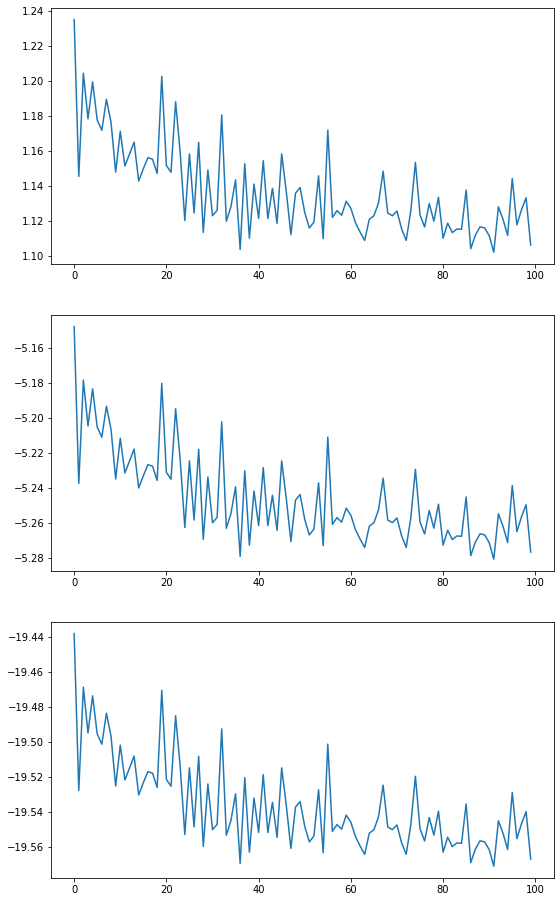

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 16))
plt.subplot(3, 1, 1)
plt.plot(epoch_pred_loss_list)
plt.subplot(3, 1, 2)
plt.plot(epoch_enc_id_loss_list)
plt.subplot(3, 1, 3)
plt.plot(epoch_clus_loss_list)
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
real, preds = [], []
with torch.no_grad():
    for step_, (x_train, y_train) in enumerate(test_loader):
        y_pred, probs = model.forward_pass(x_train)
        preds.extend(list(y_pred.cpu().detach().numpy()))
        real.extend(list(y_train.numpy()))

roc_auc_score(y_true=real, y_score=preds)

0.6223151635949378

In [ ]:
# Define your learning rate scheduler
class MyLRScheduler():
    def __init__(self, optimizer, patience, min_lr, factor):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.wait = 0
        self.best_loss = float('inf')
        
    def step(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.wait = 0
                for param_group in self.optimizer.param_groups:
                    old_lr = param_group['lr']
                    new_lr = max(old_lr * self.factor, self.min_lr)
                    param_group['lr'] = new_lr

# Instantiate your learning rate scheduler
lr_scheduler = MyLRScheduler(optimizer, patience=10, min_lr=0.00001, factor=0.25)

# During training loop
for epoch in range(num_epochs):
    # Train your model
    train_loss = train(model, train_loader, criterion, optimizer)
    
    # Evaluate your model
    val_loss = evaluate(model, val_loader, criterion)
    
    # Update the learning rate scheduler
    lr_scheduler.step(epoch, val_loss)